In [1]:

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, os, re, string
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('fake_news.csv')
df =df.reindex(np.random.permutation(df.index))
df.head()

,Unnamed: 0,title,text,label
12780,12780,Scotland's Sturgeon says staying in EU customs...,EDINBURGH (Reuters) - Scotland s First Ministe...,TRUE
39716,39716,LEFT-WING AUTHOR Blasts Democrats for “Scandal...,While many on the left continue to accuse Pres...,FAKE
20342,20342,Australia kicks off weeks-long same-sex marria...,SYDNEY (Reuters) - Australia on Tuesday launch...,TRUE
27668,27668,"One Thing Changed About Obama This Year, And ...",While much of the focus of the election year s...,FAKE
17636,17636,"Russia regrets U.S. withdrawal from UNESCO, sa...",MOSCOW (Reuters) - Russia s foreign ministry s...,TRUE


In [4]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)
df.head()

,title,text,label
12780,Scotland's Sturgeon says staying in EU customs...,EDINBURGH (Reuters) - Scotland s First Ministe...,TRUE
39716,LEFT-WING AUTHOR Blasts Democrats for “Scandal...,While many on the left continue to accuse Pres...,FAKE
20342,Australia kicks off weeks-long same-sex marria...,SYDNEY (Reuters) - Australia on Tuesday launch...,TRUE
27668,"One Thing Changed About Obama This Year, And ...",While much of the focus of the election year s...,FAKE
17636,"Russia regrets U.S. withdrawal from UNESCO, sa...",MOSCOW (Reuters) - Russia s foreign ministry s...,TRUE


In [5]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [6]:
df.head()

,title,text,label
12780,Scotland's Sturgeon says staying in EU customs...,EDINBURGH (Reuters) - Scotland s First Ministe...,TRUE
39716,LEFT-WING AUTHOR Blasts Democrats for “Scandal...,While many on the left continue to accuse Pres...,FAKE
20342,Australia kicks off weeks-long same-sex marria...,SYDNEY (Reuters) - Australia on Tuesday launch...,TRUE
27668,"One Thing Changed About Obama This Year, And ...",While much of the focus of the election year s...,FAKE
17636,"Russia regrets U.S. withdrawal from UNESCO, sa...",MOSCOW (Reuters) - Russia s foreign ministry s...,TRUE


In [7]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

## feature engineering

In [9]:
nltk.download('stopwords')
## A. TOTAL NUMBER OF WORDS USED 
df['nb_words'] = df.title.apply(lambda x: len(x.split()))

## B. TOTAL NUMBER OF UNIQUE WORDS USED
df['nb_unique_words'] = df.title.apply(lambda x: len(set(x.split())))

## C. TOTAL NUMBER OF CHARACTERS USED
df['nb_char'] = df.title.apply(lambda x: len(x))

# D. TOTAL SPECIAL CHARACTERS USED

df["nb_special"] = df.apply(lambda p: sum( not q.isalpha() for q in p["title"] ), axis=1)

## D. TOTAL NUMBER OF PUNCTUATION USED
def punct(text):
    return(len([w for w in text.split() if w in list(string.punctuation)]))
df['nb_punct'] = df.title.apply(lambda x: punct(x))

## E. TOTAL NUMBER OF STOPWORDS USED
stopword = stopwords.words('english')
def stop(text):
    return(len([w for w in text.split() if w in stopword]))
df['nb_stopwords'] = df.title.apply(lambda x: stop(x))

## F. TOTAL NUMBER OF TITLE WORDS USED
def title(text):
    return(len([w for w in text.split() if w.istitle()]))
df['nb_title_case'] = df.title.apply(lambda x: title(x))

## G. TOTAL NUMBER OF UPPERCASE WORDS USED
def upper(text):
    return(len([w for w in text.split() if w.isupper()]))
df['nb_title_case'] = df.title.apply(lambda x: upper(x))

## H. NUMBER OF MOST FREQUENT TERMS
token = nltk.word_tokenize(''.join(df.title))
frequent = nltk.FreqDist(token)
frequent.most_common(15)


[nltk_data] Downloading package stopwords to C:\Users\Sadhvi
[nltk_data]     Koli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


[(':', 13638),
 ('’', 13531),
 ('Trump', 10821),
 (',', 9779),
 ('to', 8950),
 ('To', 7565),
 ('s', 5879),
 ('”', 5470),
 ('VIDEO', 5329),
 ('[', 5239),
 (']', 5238),
 ('in', 5031),
 ('“', 5028),
 ('The', 4571),
 ('(', 4231)]

In [10]:
## REMOVING PUNCTUATION AND STOPWORDS FROM MOST FREQUENT WORDS
for sym in string.punctuation:
    del frequent[sym]
for word in stopword:
    del frequent[word]
frequent.most_common(15)

[('’', 13531),
 ('Trump', 10821),
 ('To', 7565),
 ('”', 5470),
 ('VIDEO', 5329),
 ('“', 5028),
 ('The', 4571),
 ("'s", 4153),
 ('For', 3969),
 ('In', 3579),
 ('Of', 3440),
 ('‘', 3438),
 ('A', 3088),
 ('Video', 2987),
 ('U.S.', 2910)]

In [11]:
## I. NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS 
freq_words = list(dict(frequent.most_common()[:100]).keys())
def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.title.apply(lambda x: freq(x))

In [12]:
df.head()

,title,text,label,nb_words,nb_unique_words,nb_char,nb_special,nb_punct,nb_stopwords,nb_title_case,nb_freq_words
12780,Scotland's Sturgeon says staying in EU customs...,EDINBURGH (Reuters) - Scotland s First Ministe...,TRUE,13,13,81,13,0,4,1,1
39716,LEFT-WING AUTHOR Blasts Democrats for “Scandal...,While many on the left continue to accuse Pres...,FAKE,13,13,108,23,0,1,2,0
20342,Australia kicks off weeks-long same-sex marria...,SYDNEY (Reuters) - Australia on Tuesday launch...,TRUE,7,7,55,8,0,1,0,0
27668,"One Thing Changed About Obama This Year, And ...",While much of the focus of the election year s...,FAKE,12,12,75,13,0,0,0,7
17636,"Russia regrets U.S. withdrawal from UNESCO, sa...",MOSCOW (Reuters) - Russia s foreign ministry s...,TRUE,11,11,78,13,0,1,2,3


In [13]:
## J. AVERAGE OF FREQ TERMS WITH TOTAL WORDS USED
freq_words = list(dict(frequent.most_common()[:100]).keys())
def freq(text):
    return(len([w for w in text.split() if w in freq_words])/len(text.split()))
df['avg_freq_word']= df.title.apply(lambda x: freq(x))

In [14]:
df.head()

,title,text,label,nb_words,nb_unique_words,nb_char,nb_special,nb_punct,nb_stopwords,nb_title_case,nb_freq_words,avg_freq_word
12780,Scotland's Sturgeon says staying in EU customs...,EDINBURGH (Reuters) - Scotland s First Ministe...,TRUE,13,13,81,13,0,4,1,1,0.076923
39716,LEFT-WING AUTHOR Blasts Democrats for “Scandal...,While many on the left continue to accuse Pres...,FAKE,13,13,108,23,0,1,2,0,0.000000
20342,Australia kicks off weeks-long same-sex marria...,SYDNEY (Reuters) - Australia on Tuesday launch...,TRUE,7,7,55,8,0,1,0,0,0.000000
27668,"One Thing Changed About Obama This Year, And ...",While much of the focus of the election year s...,FAKE,12,12,75,13,0,0,0,7,0.583333
17636,"Russia regrets U.S. withdrawal from UNESCO, sa...",MOSCOW (Reuters) - Russia s foreign ministry s...,TRUE,11,11,78,13,0,1,2,3,0.272727


## exploratory Data Analysis

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [18]:
df_fake = df[df['label']=='FAKE']
df_true = df[df['label']=='TRUE']

<AxesSubplot:ylabel='Frequency'>

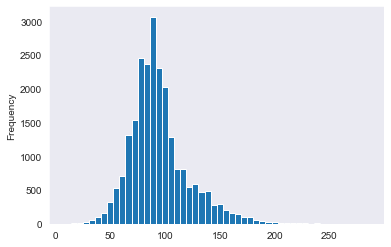

In [19]:
df_fake['nb_char'].plot(bins=50, kind='hist')

In [20]:
df_fake['nb_char'].describe()

count    23481.000000
mean        94.198032
std         27.184433
min          8.000000
25%         77.000000
50%         90.000000
75%        105.000000
max        286.000000
Name: nb_char, dtype: float64

<AxesSubplot:ylabel='Frequency'>

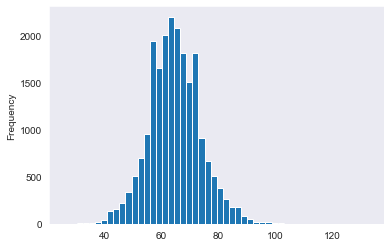

In [21]:
df_true['nb_char'].plot(bins=50, kind='hist')

In [22]:
df_true['nb_char'].describe()

count    21417.000000
mean        64.667881
std          9.168999
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: nb_char, dtype: float64

As we can see, from above analysis average number of characters in a sentence in real news is around 64 while in case of fake news it is around 94 which is but obvious because fake news generally use superflous language with more characters to grab the attention

<AxesSubplot:ylabel='Frequency'>

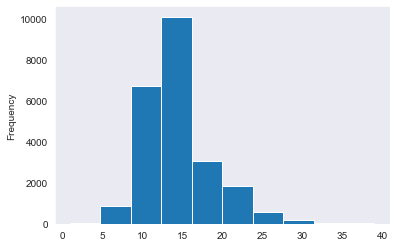

In [23]:
df_fake['nb_unique_words'].plot(bins=10, kind='hist')

In [24]:
df_fake['nb_unique_words'].describe()

count    23481.000000
mean        14.490609
std          4.129960
min          1.000000
25%         12.000000
50%         14.000000
75%         16.000000
max         39.000000
Name: nb_unique_words, dtype: float64

<AxesSubplot:ylabel='Frequency'>

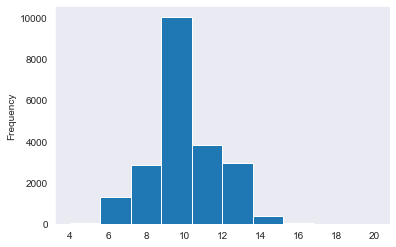

In [25]:
df_true['nb_unique_words'].plot(bins=10, kind='hist')

In [26]:
df_true['nb_unique_words'].describe()

count    21417.000000
mean         9.876827
std          1.656130
min          4.000000
25%          9.000000
50%         10.000000
75%         11.000000
max         20.000000
Name: nb_unique_words, dtype: float64

### Observation:
As we can see average number of unique words in real headlines is relatively less in comparison to fake news

C:\Users\Sadhvi Koli\AppData\Local\Temp\ipykernel_18216\2947344286.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_fake['nb_words'])


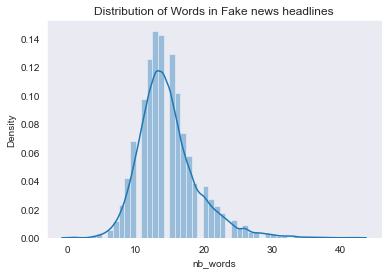

In [27]:
# distribution of fake words in Headline
sns.distplot(df_fake['nb_words'])
plt.title("Distribution of Words in Fake news headlines")
plt.show()

C:\Users\Sadhvi Koli\AppData\Local\Temp\ipykernel_18216\2072667133.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_true['nb_words'])


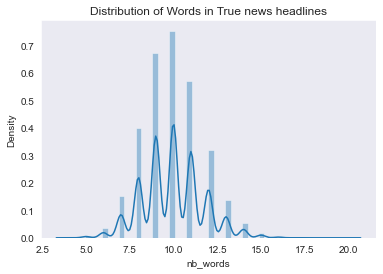

In [28]:
# distribution of  words in Real news Headline
sns.distplot(df_true['nb_words'])
plt.title("Distribution of Words in True news headlines")
plt.show()

C:\Users\Sadhvi Koli\AppData\Local\Temp\ipykernel_18216\1365854307.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_true['nb_special'])


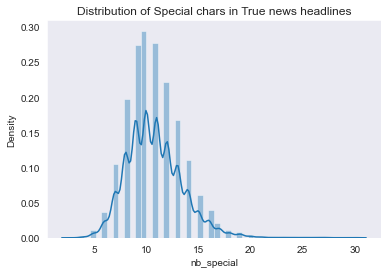

In [29]:
# distribution of  special characters in Real news Headline
sns.distplot(df_true['nb_special'])
plt.title("Distribution of Special chars in True news headlines")
plt.show()

C:\Users\Sadhvi Koli\AppData\Local\Temp\ipykernel_18216\223114589.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_fake['nb_special'])


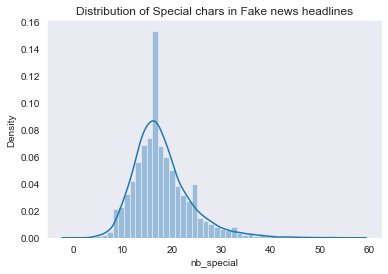

In [30]:
# distribution of  special characters in Fake news Headline
sns.distplot(df_fake['nb_special'])
plt.title("Distribution of Special chars in Fake news headlines")
plt.show()

### Observation:
As we can see there are more special characters in fake news than real news because real news is generally to the point no superflous words or less use of special characters 

In [31]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df['title']=df['title'].apply(remove_stopwords)

## Plotting Wordcloud

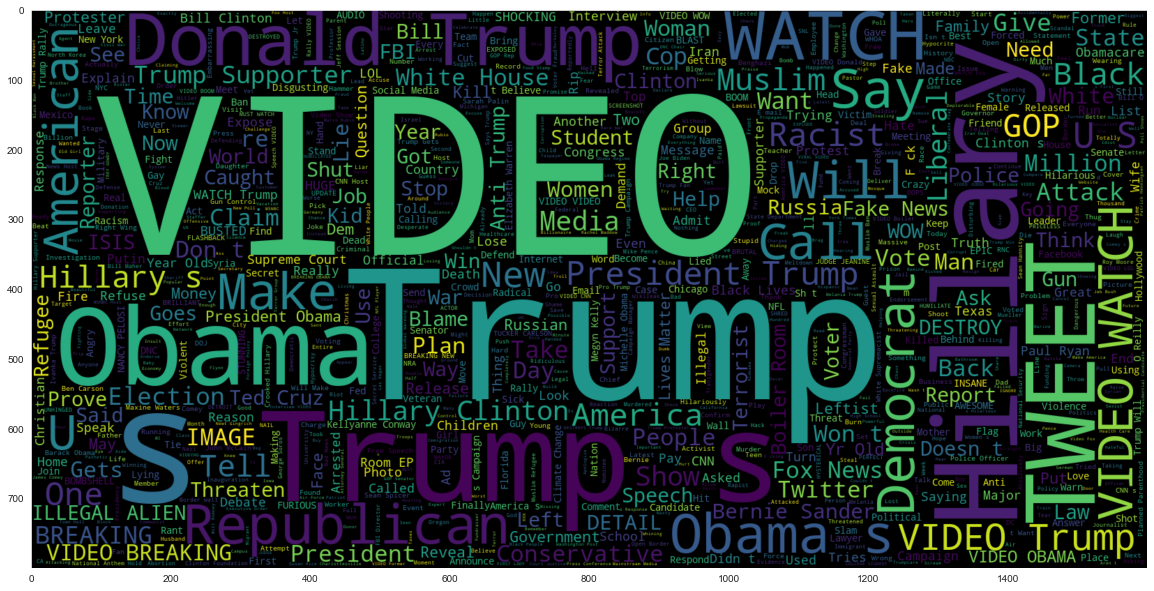

In [32]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_fake.title))
plt.imshow(wc , interpolation = 'bilinear')

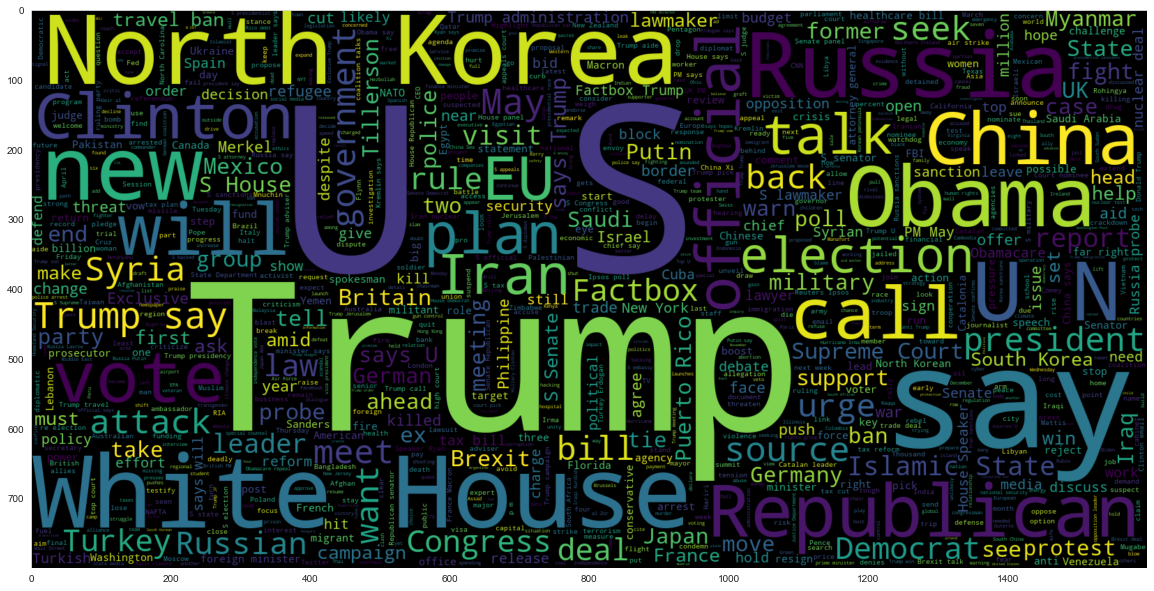

In [33]:
plt.figure(figsize = (20,20)) # Text that is True News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_true.title))
plt.imshow(wc , interpolation = 'bilinear')